In [2014]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC, Accuracy, SparseCategoricalAccuracy

import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter

In [2015]:
# Defining Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
COLOR_MODE = 'grayscale'
# COLOR_MODE = 'rgb'
BATCH_SIZE = 128

### Load Data from Disk

In [2017]:
# Load Training and Validation data
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Covid19-dataset/train",
  validation_split=0.2,
  subset="training",
  color_mode=COLOR_MODE,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
  "Covid19-dataset/train",
  validation_split=0.2,
  subset="validation",
  color_mode=COLOR_MODE,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 5231 files belonging to 3 classes.
Using 4185 files for training.
Found 5231 files belonging to 3 classes.
Using 1046 files for validation.


In [2018]:
# Load Set Aside Test Data
test_ds = tf.keras.utils.image_dataset_from_directory(
  "Covid19-dataset/test",
  color_mode=COLOR_MODE,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle=False
)

Found 295 files belonging to 3 classes.


### Data Exploration and Visualization

In [2020]:
class_names = train_ds.class_names
class_names

['Covid', 'Normal', 'Pneumonia']

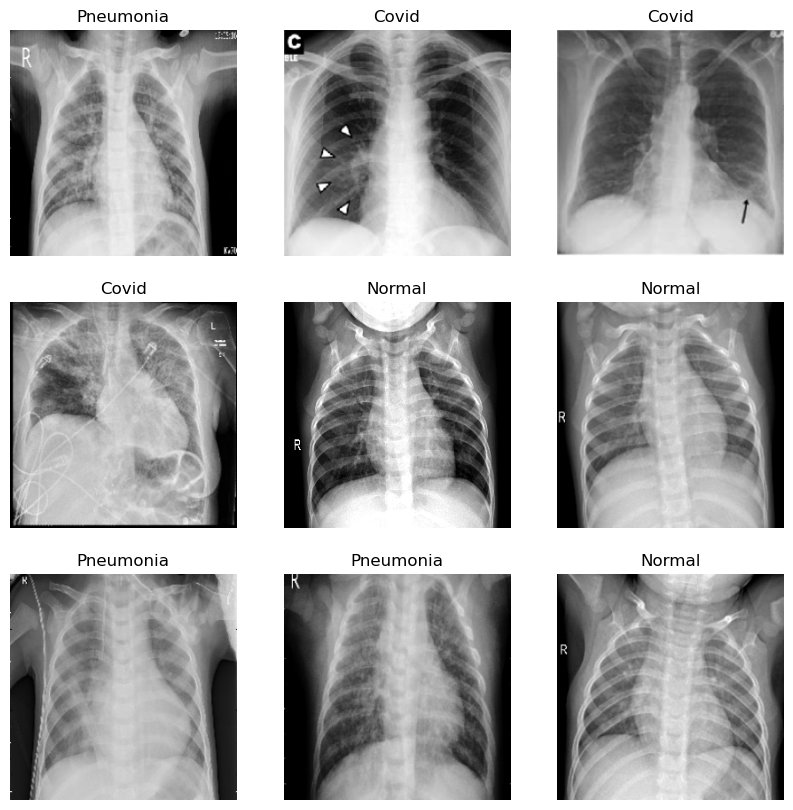

In [2021]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

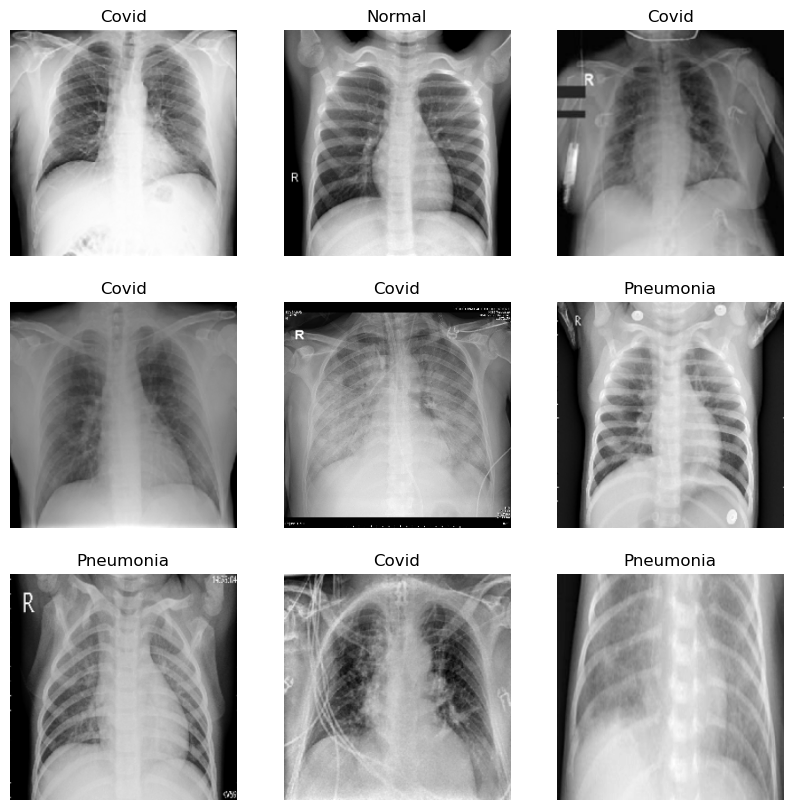

In [2022]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [2023]:
# Examine label distrubution

# Initialize a Counter
train_ds_label_counts = Counter()
# Iterate through training dataset
for images, labels in train_ds:
    train_ds_label_counts.update(labels.numpy())  # Update counts with current batch labels
    
# Initialize a Counter
val_ds_label_counts = Counter()
# Iterate through validation dataset
for images, labels in val_ds:
    val_ds_label_counts.update(labels.numpy())  # Update counts with current batch labels

# Display total label counts
print("Total label counts in the training dataset:", train_ds_label_counts)
print("Total label counts in the validation dataset:", val_ds_label_counts)

Total label counts in the training dataset: Counter({1: 1426, 2: 1424, 0: 1335})
Total label counts in the validation dataset: Counter({2: 378, 1: 377, 0: 291})


### Preprocess and Normalize Dataset

In [2025]:
# Optimize data for performance and GPU utilization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Create Model

In [2027]:
# Create Model
channel = 1
if COLOR_MODE == "rgb":
    channel = 3

model = Sequential()
model.add(layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channel)))

# Augment data 
# model.add(layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# model.add(layers.RandomRotation(0.1))
# model.add(layers.RandomZoom(0.1))

# Rescale pixel values to 0 - 1
model.add(layers.Rescaling(1./255))

# CNN Layers
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
# model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
# model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))

# Output Layer
# model.add(layers.Dense(3, activation='softmax'))
# We specify activation=None so as to return logits
model.add(layers.Dense(3, activation=None))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

model.summary()

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_62 (Rescaling)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_123               │ (None, 128, 128, 16)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_124               │ (None, 64, 64, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_125               │ (None, 32, 32, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_56 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,048,995 (4.00 MB)

 Trainable params: 1,048,995 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

### Fit and Evaluate Model

In [2029]:
# Fit Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)
n_train = 4185
n_val = 1046
history = model.fit(
    train_ds, 
    # steps_per_epoch=math.ceil(n_train/BATCH_SIZE),
    validation_data=val_ds, 
    # validation_steps=math.ceil(n_val/BATCH_SIZE),
    epochs=15, callbacks=[early_stopping], verbose=1
)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 325ms/step - accuracy: 0.4902 - loss: 1.3900 - val_accuracy: 0.8967 - val_loss: 0.3757
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.8818 - loss: 0.3446 - val_accuracy: 0.9331 - val_loss: 0.2124
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.9238 - loss: 0.2313 - val_accuracy: 0.9407 - val_loss: 0.1764
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.9372 - loss: 0.1836 - val_accuracy: 0.9541 - val_loss: 0.1491
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.9486 - loss: 0.1548 - val_accuracy: 0.9589 - val_loss: 0.1384
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.9531 - loss: 0.1400 - val_accuracy: 0.9579 - val_loss: 0.1354
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.9581 - loss: 0.1271 - val_accuracy: 0.9665 - val_loss: 0.1255
Epoch 8/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 316ms/step - accuracy: 0.9586 - loss: 0.1162 - val_accu

In [2030]:
# history.history

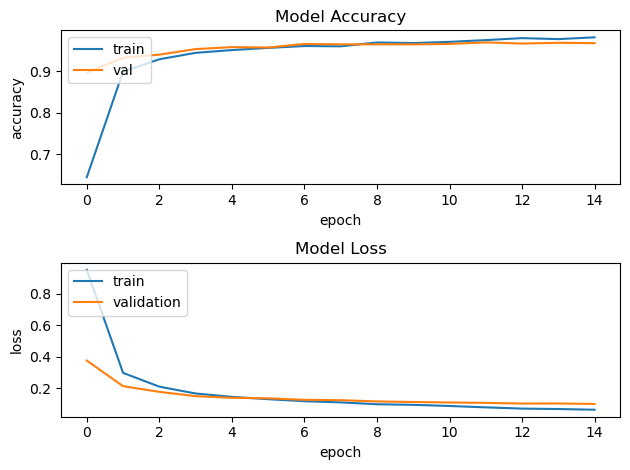

In [2031]:
# Plot Performances over epoch

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'val'], loc='upper left')

# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [2032]:
pred_classes = model.predict(test_ds)
pred_classes = np.argmax(pred_classes, axis=1)
true_classes = []
# Loop through all batches in the test dataset to collect labels
for images, labels in test_ds:
    true_classes.extend(labels.numpy())
true_classes = np.array(true_classes)
report = classification_report(true_classes, pred_classes, target_names=class_names)
print(report) 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
              precision    recall  f1-score   support

       Covid       0.99      0.99      0.99       125
      Normal       0.91      0.95      0.93        85
   Pneumonia       0.95      0.91      0.93        85

    accuracy                           0.96       295
   macro avg       0.95      0.95      0.95       295
weighted avg       0.96      0.96      0.96       295



In [2033]:
loss, metric = model.evaluate(test_ds)
print(f"Loss: {loss}\nAccuracy: {metric}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9682 - loss: 0.1133
Loss: 0.14848436415195465
Accuracy: 0.9559321999549866


In [2034]:
# # Predict new Xray Image
# img_url = "https://prod-images-static.radiopaedia.org/images/1371188/0a1f5edc85aa58d5780928cb39b08659c1fc4d6d7c7dce2f8db1d63c7c737234_big_gallery.jpeg"
# img_path = tf.keras.utils.get_file('0a1f5edc85aa58d5780928cb39b08659c1fc4d6d7c7dce2f8db1d63c7c737234_big_gallery', origin=img_url)

# img = tf.keras.utils.load_img(
#     img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

### References

* *Training Dataset: Kumar, Sachin (2022), “Covid19-Pneumonia-Normal Chest X-Ray Images”, Mendeley Data, V1, doi: 10.17632/dvntn9yhd2.1*
* *PA Dataset: Asraf, Amanullah; Islam, Zabirul (2021), “COVID19, Pneumonia and Normal Chest X-ray PA Dataset”, Mendeley Data, V1, doi: 10.17632/jctsfj2sfn.1*
* *Testing Dataset: Codecademy*